In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from error_model_utils import *

# --- Generated synthetic “ref” data ---
n = 1000
ref = {
    'O': np.random.rand(n),                   # observed
    'B-rttov12': 0.8 * np.random.rand(n),     # synthetic #1
    'B-rttov13': 0.9 * np.random.rand(n),     # synthetic #2
    'SZA':  90 * np.random.rand(n),           # solar zenith angle [0–90°]
}

# Map labels → ref-keys
operators = {
    'rttov12': 'B-rttov12',
    'rttov13': 'B-rttov13'
}

# --- Run the core pipeline ---
df, stats = build_error_dataframe(
    ref,
    operators, # Define your different operators tested
    flatten_fn=flatten_array,
    cloud_impact_fn=cloud_impact_av, 
    obs_key='O',
    sza_key='SZA',
    obs_min=0.0, # default, input for the defined mask
    sza_max=70.0, # default, input for the defined mask
    threshold=0.0 # default, check out the function
)

In [2]:
#df

In [3]:
print("Head of the full error‐model DataFrame:")
print(df.head())

print("\nPer‐operator summary stats (mean, std) of departures:")
for lbl, (m, s) in stats.items():
    print(f"  {lbl}: mean={m:.3f}, std={s:.3f}")


Head of the full error‐model DataFrame:
   OmB_rttov12  C_av_rttov12  Cx_rttov12  OmB_rttov13  C_av_rttov13  \
0    -0.103795      0.530505    0.582403     0.176856      0.390180   
1     0.056949      0.249988    0.221514    -0.143637      0.350281   
2     0.244243      0.771374    0.649253     0.045951      0.870520   
3     0.286120      0.760431    0.617371     0.853714      0.476634   
4     0.166909      0.491822    0.408368    -0.233628      0.692091   

   Cx_rttov13        Cy  
0    0.301752  0.478608  
1    0.422100  0.278463  
2    0.847545  0.893496  
3    0.049777  0.903491  
4    0.808905  0.575277  

Per‐operator summary stats (mean, std) of departures:
  rttov12: mean=0.115, std=0.364
  rttov13: mean=0.071, std=0.391


/home/sandy/Satellite_DA/Non-Gaussian-errors/error_model_utils.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(pd.cut(df[predictor], bins=bins))[target]


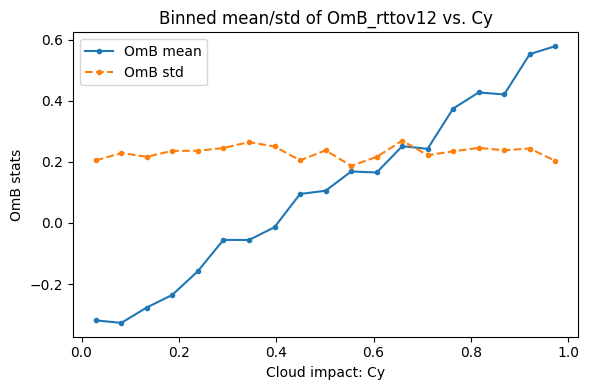

In [4]:
# --- Bin and plot one predictor as example ---
binned_Co = compute_binned_stats(df, predictor='Cy', target='OmB_rttov12', n_bins=20)

fig, ax = plt.subplots(figsize=(6,4))
plot_binned_comparison(
    binned=binned_Co,
    predictor_mid='Cy_mid',
    mean_col='mean',
    std_col='std',
    label='OmB',
    ax=ax
)
ax.set_title("Binned mean/std of OmB_rttov12 vs. Cy")
ax.set_xlabel("Cloud impact: Cy")
ax.set_ylabel("OmB stats")
plt.tight_layout()
plt.show()

In [5]:
df.head()

,OmB_rttov12,C_av_rttov12,Cx_rttov12,OmB_rttov13,C_av_rttov13,Cx_rttov13,Cy
0,-0.103795,0.530505,0.582403,0.176856,0.390180,0.301752,0.478608
1,0.056949,0.249988,0.221514,-0.143637,0.350281,0.422100,0.278463
2,0.244243,0.771374,0.649253,0.045951,0.870520,0.847545,0.893496
3,0.286120,0.760431,0.617371,0.853714,0.476634,0.049777,0.903491
4,0.166909,0.491822,0.408368,-0.233628,0.692091,0.808905,0.575277


In [6]:
# 1. Bin the two C_av predictors into DataFrames with columns
#    ['C_av_<label>_mid', 'mean', 'std']:
binned_Ca12 = compute_binned_stats(
    df,
    predictor='C_av_rttov12',
    target='OmB_rttov12',
    n_bins=25
)
binned_Ca13 = compute_binned_stats(
    df,
    predictor='C_av_rttov13',
    target='OmB_rttov13',
    n_bins=25
)


/home/sandy/Satellite_DA/Non-Gaussian-errors/error_model_utils.py:114: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(pd.cut(df[predictor], bins=bins))[target]


In [7]:
dynamic_bins = {
    'rttov12': binned_Ca12,
    'rttov13': binned_Ca13
}

df = normalize_departures(df, stats, dynamic_bins)

print(df[['OmB_rttov12','norm-rttov12']].head())


   OmB_rttov12  norm-rttov12
0    -0.600405     -0.509052
1    -0.158679     -0.203243
2     0.356009      0.929831
3     0.471085      1.177197
4     0.143493      0.109729


## To DO - Plot PDFs and compare departures with constant and dynamic error

In [ ]:
def plot_distributions(data:pd.DataFrame, variables:list, labels:list, title=None, correction=None, 
                       mean:list=None,std:list=None, save=None,out_path="./",name=None):
    """
    Plots the distributions of two variables from a dataframe against a normal distribution.
    Returns the created plot.

    Args:
        data (dataframe): The input dataframe containing the variables.
        variables (list): A list of two column names representing the variables to plot.
        labels (list): A list of two strings representing the labels for the variables in the legend.
        title (str, optional): The title of the plot. Defaults to None.

    Returns:
        matplotlib.figure.Figure: The created plot figure.
    """
    # Generate normal distribution data mu - 4*sigma, mu + 4*sigma, 1000
    x = np.linspace(mean[0] - 5 * std[0], mean[0] + 5 * std[0], 100)
    normal_dist_1 = norm.pdf(x, mean[0], std[0])

    # Create plot
    fig, ax = plt.subplots(figsize=(6, 5))  # Single subplot

    # Style plot elements
    font_color = 'black'
    plt.rc('xtick', color=font_color)
    plt.rc('ytick', color=font_color)
    plt.rc('axes', labelcolor=font_color, titlecolor=font_color) 

    # Plot distributions
    sns.kdeplot(x=data[variables[0]].to_numpy().flatten(), common_norm=True, log_scale=(False, False), 
                color="deepskyblue", ax=ax, linewidth=3, label=labels[0])
    if correction:
        sns.kdeplot(x=data[variables[1]].to_numpy().flatten(), common_norm=True, log_scale=(False, False), 
                color="red", ax=ax, linewidth=3, label=labels[1])
    ax.plot(x, normal_dist_1, color='grey', linestyle='-', label=f"Gaussian (mean={mean[0]}, \n std={std[0]})")
    
    # Set plot limits and labels
    #ax.set_ylim(10e-4, 10e1)
    ax.set_xlim(-4,4) #-0.05, 0.05
    ax.set_xlabel('Normalized OmB departures', fontsize=14)
    ax.set_ylabel('PDF', fontsize=14)

    # Set title if provided
    if title:
        ax.set_title(title, fontsize=14)

    # Customize ticks and legend
    ax.tick_params(axis='both', labelsize=14)
    ax.legend(fontsize=12)
    #ax.set_xticks(range(-6, 6, 1))
    if save:
        plt.savefig(f"{out_path}/{name}.png")
    # Return the plot figure
    return fig

In [ ]:
plot_figure = plot_distributions(data=df,variables=['V12', "norm-V12"],labels=['v12', "corrected-v12"],
title=f"",correction=True,mean=[0,0], std=[1,1],
save=True,name="sensitivity_Ca/All_dist_v12_case_9")

In [ ]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(8, 6))
xrange=[-3.5,3.5]
axes[0].hist(df["V12"],range=xrange,color="deepskyblue", histtype="step", lw=2, label="constant std")
axes[0].hist(df["norm-V12"],range=xrange, color="red",  histtype="step", lw=2, label="dynamic std")
axes[0].set_title("V12")
axes[0].set_xlabel('')
axes[0].set_xticks([])
axes[0].set_ylabel('Counts')
axes[0].legend()
axes[0].tick_params(axis='x')

axes[1].hist(df["V13"],range=xrange,color="deepskyblue", histtype="step",lw=2, label="constant std")
axes[1].hist(df["norm-V13"],range=xrange, color="red", histtype="step", lw=2,label="dynamic std")
axes[1].set_title("V13")
axes[1].set_xlabel('Normalized OmB departures')
axes[1].set_ylabel('Counts')
axes[1].legend()
axes[1].tick_params(axis='x')

plt.tight_layout()
plt.savefig("./sensitivity_Ca/hist_v12_case_9.png")
plt.show()